# GHCNh false positive rate

## Load libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.ticker import MaxNLocator
import sys

ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
from GHCNh_lib import GHCNh  # If GHCNh is was appended to path
from qaqc_eval_utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## GHCNh dataset

### GHCNh test the convert to geopandas DataFrame

In [2]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df["id"].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))
ghcnh.station_data.head(3)

CAW00025343, -133.05000, 54.25000
CPU times: user 2.8 s, sys: 180 ms, total: 2.98 s
Wall time: 2.98 s


,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID,time,geometry
0,CAW00025343,LANGARA,1954,1,1,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 09:00:00,POINT (-14811058.250 7217646.198)
1,CAW00025343,LANGARA,1954,1,1,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 21:00:00,POINT (-14811058.250 7217646.198)
2,CAW00025343,LANGARA,1954,1,2,3,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 03:00:00,POINT (-14811058.250 7217646.198)


## Train stations and even evaluation

### Read in stations

In [3]:
train_stns = pd.read_csv("../qaqc_training_station_list_events.csv")

### How to identify other events of interest using a start and end date

In [4]:
alt_start_date = "2007-10-20"
alt_end_date = "2007-10-24"
alt_event_stns = find_other_events(
    train_stns, event_start=alt_start_date, event_end=alt_end_date, buffer=14, subset=5
)
alt_event_stns.head(3)

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['HADS_MCAA2', 'RAWS_PARN8', 'HADS_WHRU1', 'ASOSAWOS_72783024149', 'ASOSAWOS_72797094240']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
446,HADS,HADS_MCAA2,44.0,58.398060,-134.60944,2007-03-22 00:00:00+00:00,2023-01-16 16:00:00+00:00,"AR, mudslide, aug2020_heatwave, sep2020_heatwa...",NaN
847,RAWS,RAWS_PARN8,2101.0,47.974167,-102.22250,2002-04-18 00:00:00+00:00,2013-07-28 19:02:00+00:00,NaN,NaN
474,HADS,HADS_WHRU1,7361.0,40.600560,-109.92639,2000-01-17 00:00:00+00:00,2023-01-16 16:00:00+00:00,"AR, mudslide, aug2020_heatwave, sep2020_heatwa...",NaN


### Original functionality of `subset_eval_stns` function, random sampling from trainint stations

In [5]:
eval_stations = subset_eval_stns(
    event_to_eval="santa_ana_wind", stn_list=train_stns, subset=5, return_stn_ids=True
)
eval_stations.head(3)

17 potential stations available for evaluation for santa_ana_wind event.
5 stations selected for evaluation for santa_ana_wind event!
Stations selected for evaluation:
 ['ASOSAWOS_72383023187', 'ASOSAWOS_72297023129', 'CIMIS_45', 'ASOSAWOS_72292023191', 'ASOSAWOS_72288023152']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
7,ASOSAWOS,ASOSAWOS_72383023187,1374.6480,34.744,-118.725,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13216406.544 4129145.958)
4,ASOSAWOS,ASOSAWOS_72297023129,10.3632,33.812,-118.147,1943-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13152063.879 4003586.068)
12,CIMIS,CIMIS_45,370.0000,32.787,-117.135,1985-06-09 00:00:00+00:00,1989-04-27 00:00:00+00:00,santa_ana_wind,NaN,06,...,41740,NaN,A,1.090437e+10,8.174046e+08,+33.0236041,-116.7761174,553042.602989,1.672201e+10,POINT (-13039408.554 3867065.784)


In [6]:
eval_stations["era-id"].values[-1]
# eval_stations.loc[eval_stations['era-id']==stn_id]

'ASOSAWOS_72288023152'

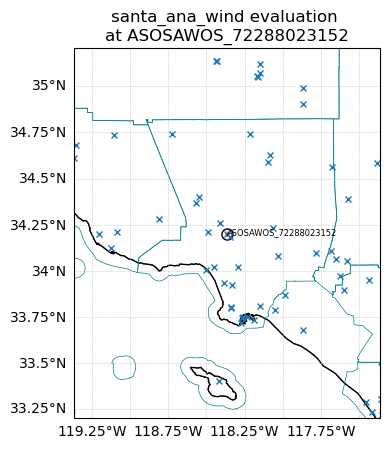

In [7]:
fig, ax = stn_visualize(
    stn_id=eval_stations["era-id"].values[-1],
    stn_list=eval_stations,
    event_to_eval="santa_ana_wind",
)

ax.plot(
    ghcnh.stations_df.longitude,
    ghcnh.stations_df.latitude,
    "x",
    markersize=4,
    transform=ccrs.PlateCarree(),
    mfc="none",
)

### New addition, specific station flag

<div style="width: 50em;">
Specific station flag introduced to control which station we are analyzing
Useful for debugging, down the line this would help to manage using the same
station and not download different stations every time in the nearest stations
part (down)
</div>

In [56]:
""" Test when station is not in the training/event dataframe
This would lead to the error:
'ValueError: Station CIMIS_80 is not within the training/event dataset'
"""

# eval_stations = subset_eval_stns(
#     event_to_eval = 'santa_ana_wind',
#     stn_list = train_stns,
#     specific_station='CIMIS_80',
#     return_stn_ids = True
# )
# eval_stations

" Test when station is not in the training/event dataframe\nThis would lead to the error:\n'ValueError: Station CIMIS_80 is not within the training/event dataset'\n"

In [9]:
# specific_station = 'CIMIS_45'
specific_station = "CIMIS_75"

In [10]:
eval_stations = subset_eval_stns(
    event_to_eval="santa_ana_wind",
    stn_list=train_stns,
    specific_station=specific_station,
    return_stn_ids=True,
)
eval_stations

17 potential stations available for evaluation for santa_ana_wind event.


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,geometry
82,CIMIS,CIMIS_75,410.0,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN,POINT (-13104661.813 3987044.797)


#### Plot 'specific station' from the training and the GHCNh stations in the 'area'

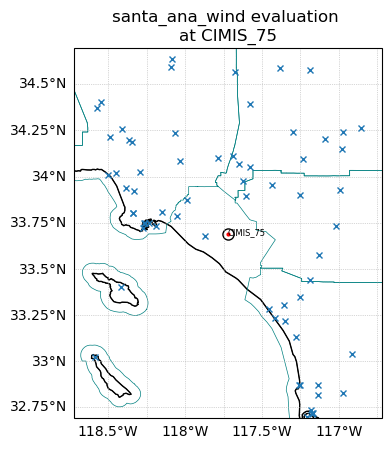

In [11]:
fig, ax = stn_visualize(
    stn_id=specific_station, stn_list=eval_stations, event_to_eval="santa_ana_wind"
)

ax.plot(
    ghcnh.stations_df.longitude,
    ghcnh.stations_df.latitude,
    "x",
    markersize=4,
    transform=ccrs.PlateCarree(),
    mfc="none",
)

## GHCNh stations distance to the testing stations

<div style="width: 50em;">
Create a distnace to specific station column for the ghcnh dataframe
Then, sort by distance to have the nearest stations to the one we are evaluating
</div>

### Create distance and sort it

In [12]:
stn_id = eval_stations["era-id"].values[-1]
point = eval_stations.loc[eval_stations["era-id"] == stn_id].geometry.iloc[0]
ghcnh_stations_df = ghcnh.stations_df.copy()
display(eval_stations.loc[eval_stations["era-id"] == stn_id, ["longitude", "latitude"]])
ghcnh_stations_df["distance_to_eval"] = ghcnh_stations_df.distance(
    point,
)
ghcnh_stations_df = ghcnh_stations_df.sort_values(by="distance_to_eval")
ghcnh_stations_df.head(5)

,longitude,latitude
82,-117.72118,33.68845


,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,url,is_in_wecc,geometry,distance_to_eval
5627,USW00093184,33.6797,-117.8675,13.1,CA,SANTA ANA JOHN WAYNE AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13120950.081 3985874.222),16330.276109
5138,USW00053175,33.8978,-117.6025,162.5,CA,CORONA MUNICIPAL AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13091450.416 4015087.305),30998.762024
3575,USW00003166,33.8717,-117.9855,26.2,CA,FULLERTON MUNI AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13134085.781 4011587.454),38315.948053
5110,USW00053141,33.7900,-118.0519,10.7,CA,LOS ALAMITOS AAF,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13141477.395 4000638.892),39245.209887
3582,USW00003179,33.9756,-117.6250,193.9,CA,CHINO AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13093955.105 4025526.173),39943.083072


### Plot the closest 10 stations to the train/eval station

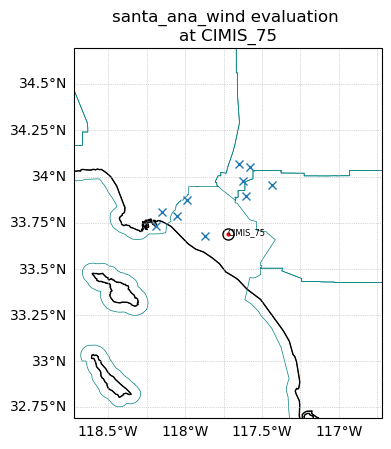

In [13]:
fig, ax = stn_visualize(
    stn_id=specific_station, stn_list=eval_stations, event_to_eval="santa_ana_wind"
)

plot_df = ghcnh_stations_df.iloc[:10]
ax.plot(
    plot_df.longitude,
    plot_df.latitude,
    "x",
    markersize=6,
    transform=ccrs.PlateCarree(),
    mfc="none",
);

In [14]:
era2ghcn_vars

{'tas': 'temperature',
 'tdps': 'dew_point_temperature',
 'tdps_derived': 'dew_point_temperature',
 'ps': 'station_level_pressure',
 'psl': 'station_level_pressure',
 'sfcWind_dir': 'wind_direction',
 'sfcWind': 'wind_speed',
 'hurs': 'relative_humidity',
 'rsds': 'N/A',
 'pr': 'precipitation',
 'pr_1h': 'precipitation',
 'pr_5min': 'precipitation'}

In [15]:
# df, vars = return_ghcn_vars(ghcnh.station_data, 'tas')

In [16]:
# len(df.temperature_Quality_Code.dropna())/len(df.temperature_Quality_Code)

In [17]:
%%time
ds = pull_nc_from_aws(specific_station)  # manually retrieve a specific station
ds

Retrieving data for station...
s3://wecc-historical-wx/3_qaqc_wx_dev/CIMIS/CIMIS_75.nc
CPU times: user 2.7 s, sys: 1.14 s, total: 3.84 s
Wall time: 26.3 s


<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) float64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [18]:
%%time
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)
df.head(3)

era_qc existing variables:
['tas_eraqc', 'pr_eraqc', 'hurs_eraqc', 'rsds_eraqc', 'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc', 'tdps_derived_eraqc', 'pvp_derived_eraqc']
0 created era_qc variables
CPU times: user 30.8 s, sys: 16.4 s, total: 47.2 s
Wall time: 5min 23s


,time,tas,pr,hurs,rsds,sfcWind,sfcWind_dir,pr_qc,rsds_qc,pvp_derived_qc,...,tdps_derived_eraqc,pvp_derived_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,1987-10-07 09:00:00,290.75,0.0,9.0,0.0,0.8,87.1,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,9,7,10,1987,1987-10-07
1,1987-10-07 10:00:00,290.85,0.0,7.0,-1.0,0.7,76.2,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,10,7,10,1987,1987-10-07
2,1987-10-07 11:00:00,290.65,0.0,7.0,-1.0,1.0,11.7,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,11,7,10,1987,1987-10-07


In [19]:
%%time
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)
df.head(3)

era_qc existing variables:
['tas_eraqc', 'pr_eraqc', 'hurs_eraqc', 'rsds_eraqc', 'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc', 'tdps_derived_eraqc', 'pvp_derived_eraqc']
0 created era_qc variables
CPU times: user 313 ms, sys: 63.1 ms, total: 376 ms
Wall time: 401 ms


,time,tas,pr,hurs,rsds,sfcWind,sfcWind_dir,pr_qc,rsds_qc,pvp_derived_qc,...,tdps_derived_eraqc,pvp_derived_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,1987-10-07 09:00:00,290.75,0.0,9.0,0.0,0.8,87.1,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,9,7,10,1987,1987-10-07
1,1987-10-07 10:00:00,290.85,0.0,7.0,-1.0,0.7,76.2,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,10,7,10,1987,1987-10-07
2,1987-10-07 11:00:00,290.65,0.0,7.0,-1.0,1.0,11.7,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,11,7,10,1987,1987-10-07


### Why is the first time `qaqc_ds_to_df` much much slower than the second? 

<div style="width: 50em;">
The first time, `s3.open()` is done. This does reads the dataset in a lazy way. When converting to df, the whole file needs
to be read to memory, which `s3.open()` does much slower than s3.download()`
</div>

<div style="width: 50em;">

_From ChatGPT:_

When comparing s3.open and s3.download, the performance difference typically depends on how data is accessed and processed. Here’s an overview of the two methods:

1. **`s3.open()`**:
Use Case: Opens a file from an S3 bucket as a file-like object.
Performance:
When using s3.open, data is streamed in smaller chunks, allowing for on-the-fly reading (useful when handling large files). This reduces memory overhead since the file is not loaded into memory at once.
However, this streaming approach can make accessing data slower, especially when performing repeated read operations, as it incurs overhead due to network latency and chunk retrieval.
2. **`s3.download()`**:
Use Case: Downloads a file from S3 and stores it locally or in memory.
Performance:
s3.download typically downloads the entire file at once, which can be faster when you need the whole file to be processed or manipulated. There’s less latency involved after the file is downloaded, as subsequent operations on the local or in-memory copy are fast.
However, downloading large files can be slower initially (compared to streaming) and can consume significant memory.
Summary:
s3.open is slower for operations that require reading large amounts of data repeatedly due to chunk-based streaming.
s3.download is faster when you need the entire file at once, as you download the full data and can work with it in memory without additional network operations.
When to Use Each:
Use s3.open() for large files or if you only need partial access to the file (e.g., processing chunks of data or streaming video).
Use s3.download() when you want the entire file available immediately or if you need faster access after the file is fully downloaded.
</div>

<div style="width: 50em;">
One way to handle this, specially for speed in debugging and testing, is to download the file to a temporary file, with the option to save to disk if we want to. Since downloading the file it's much faster, this process will be faster. Also, we can set an instruction to look first locally, if the file is not there, then download from s3 bucket
</div>

In [20]:
%%time
ds = download_nc_from_aws(specific_station)
ds

Retrieving data for station...
CPU times: user 674 ms, sys: 70.1 ms, total: 744 ms
Wall time: 828 ms


<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 290.8 290.8 ... 309.6 310.3
    pr                    (station, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hurs                  (station, time) float64 9.0 7.0 7.0 ... 27.0 24.0 24.0
    rsds                  (station, time) float64 0.0 -1.0 -1.0 ... 803.0 678.0
    sfcWind               (station, time) float64 0.8 0.7 1.0 ... 3.2 3.2 3.2
    sfcWind_dir           (station, time) float64 87.1 76.2 11.7 ... 191.0 188.0
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    elevation_eraqc       (station, time) float64 nan nan nan ... nan nan nan
    tdps_derived_eraqc    (station, time) float64 nan nan nan ... nan nan nan
    pvp_derived_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    anemometer_height_m   (station, time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    thermometer_height_m  (station, time) float64 1.5 1.5 1.5 ... 1.5 1.5 1.5
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

#### Download the file to local folder with `save=True

In [21]:
ds = download_nc_from_aws(specific_station, save=True)
ds

Retrieving data for station...


<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 290.8 290.8 ... 309.6 310.3
    pr                    (station, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hurs                  (station, time) float64 9.0 7.0 7.0 ... 27.0 24.0 24.0
    rsds                  (station, time) float64 0.0 -1.0 -1.0 ... 803.0 678.0
    sfcWind               (station, time) float64 0.8 0.7 1.0 ... 3.2 3.2 3.2
    sfcWind_dir           (station, time) float64 87.1 76.2 11.7 ... 191.0 188.0
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    elevation_eraqc       (station, time) float64 nan nan nan ... nan nan nan
    tdps_derived_eraqc    (station, time) float64 nan nan nan ... nan nan nan
    pvp_derived_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    anemometer_height_m   (station, time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    thermometer_height_m  (station, time) float64 1.5 1.5 1.5 ... 1.5 1.5 1.5
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

### Once the file was downloaded, reading from disk should be faster for testing

In [22]:
%%time
ds = download_nc_from_aws(specific_station)
ds

Retrieving data for station...
CPU times: user 658 ms, sys: 57.3 ms, total: 715 ms
Wall time: 719 ms


<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 290.8 290.8 ... 309.6 310.3
    pr                    (station, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hurs                  (station, time) float64 9.0 7.0 7.0 ... 27.0 24.0 24.0
    rsds                  (station, time) float64 0.0 -1.0 -1.0 ... 803.0 678.0
    sfcWind               (station, time) float64 0.8 0.7 1.0 ... 3.2 3.2 3.2
    sfcWind_dir           (station, time) float64 87.1 76.2 11.7 ... 191.0 188.0
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    elevation_eraqc       (station, time) float64 nan nan nan ... nan nan nan
    tdps_derived_eraqc    (station, time) float64 nan nan nan ... nan nan nan
    pvp_derived_eraqc     (station, time) float64 nan nan nan ... nan nan nan
    anemometer_height_m   (station, time) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    thermometer_height_m  (station, time) float64 1.5 1.5 1.5 ... 1.5 1.5 1.5
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [23]:
%%time
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)
df.head(3)

era_qc existing variables:
['tas_eraqc', 'pr_eraqc', 'hurs_eraqc', 'rsds_eraqc', 'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc', 'tdps_derived_eraqc', 'pvp_derived_eraqc']
0 created era_qc variables
CPU times: user 589 ms, sys: 77.4 ms, total: 666 ms
Wall time: 675 ms


,time,tas,pr,hurs,rsds,sfcWind,sfcWind_dir,pr_qc,rsds_qc,pvp_derived_qc,...,tdps_derived_eraqc,pvp_derived_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
0,1987-10-07 09:00:00,290.75,0.0,9.0,0.0,0.8,87.1,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,9,7,10,1987,1987-10-07
1,1987-10-07 10:00:00,290.85,0.0,7.0,-1.0,0.7,76.2,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,10,7,10,1987,1987-10-07
2,1987-10-07 11:00:00,290.65,0.0,7.0,-1.0,1.0,11.7,nan,nan,nan,...,NaN,NaN,2.0,1.5,CIMIS_75,11,7,10,1987,1987-10-07


#### Check if the ds_to_df problem was fixed

`ds_to_df` function was deleting all flags and converting them to nans

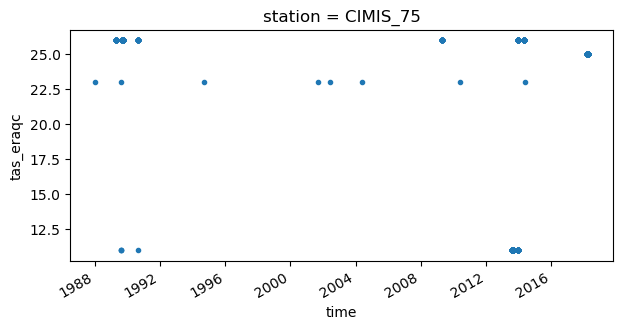

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))
ds.tas_eraqc.plot(ax=ax, marker=".", lw=0);

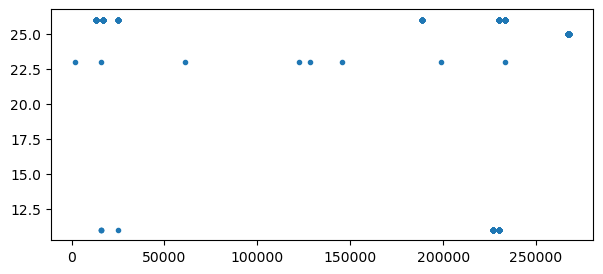

In [25]:
fig, ax = plt.subplots(figsize=(7, 3))
df.tas_eraqc.plot(ax=ax, marker=".", lw=0);

## Classification metrics: precision, recall, false positive, and false negative rates

<div style="width: 50em;">
    
**Accuracy** is the most obvious classification metric, which is defined as the number of correct predictions divided by the total number of observations.

The biggest problem with accuracy is that it will let us down in situations where one class occurs with much higher frequency than another.  
</div>

<div style="width: 50em;">

---
**Discussion**

- We are tasked to build an QA/QC that analyzes weather stations. The goal is to build a pipeline that recognize "bad" values and flags them. Accuracy aims to flag as many "bad" avlues as the ground truth "bad" observations. 
- If our QA/QC gets a 1-% accuracy score, would we be happy with this outcome?
---
When accuracy is not a useful metric, we can instead focus on the uncommon class , in this case, the flag values:
- If QA/QC pipeline marks an obvservartion as "bad", how likely is it for that obsrevation is actually an error?", or
- What percent of "real"/ground truth bad observations are correctly flagged by our pipeline?"

These are the concepts of **precision** and **recall**, respectively. 

</div>

<div style="width: 50em;">

In the figure below, "correct" observations are representend in blue and "bad" observations are red. We pick the "flag" class to be the **positive class**. The arrows denote the results of our QA/QC pipeline. A blue arrow means the pipeline classifies the observation as "good" and a red arrow means the pipeline flags the observation as "bad".

![errors](precision_recall.svg)

Notice that there are instances when the QA/QC makes a correct classification, either it classifies that a "good" observation is good (true negative) or it flags that a bad observation is bad (true positive). But occasionally it makes an error. There are two types of errors, we either flagged a good observation as "bad" (false positive, also called type I error) or we classified an "real bad" observation as correct (false negative, also called type II error). 

* **Precision** is then defined as the number of true positives divided by the number of all positive *predictions*. Maximizing precision means **minimizing false positives**.
* **Recall** is defined as number of true positives divided by the number all positive *observations*. Maximizing recall means **minimizing false negatives**.
---
</div>

<div style="width: 50em;">
    
**In summary**:

Accuracy is the number of correct predictions divided by the total number of observations:
- Minimizing false positives means maximizing precision.
- Minimizing false negatives means maximizing recall
</div>

### False positive and false negative rates

<div style="width: 50em;">

The **false positive rate (FPR)** is the proportion of all negatives that still yield positive test outcomes, i.e., the conditional probability of a positive test result given an event that was not present. The false positive rate depends on the significance level. The **specificity** of the test is equal to 1 minus the false positive rate.

- In statistical hypothesis testing, this fraction is given the Greek letter α, and 1 − α is defined as the specificity of the test. 

- Increasing the specificity of the test lowers the probability of type I errors, but may raise the probability of type II errors (false negatives that reject the alternative hypothesis when it is true).

Complementarily, the **false negative rate (FNR)** is the proportion of positives which yield negative test outcomes with the test, i.e., the conditional probability of a negative test result given that the condition being looked for is present.

- In statistical hypothesis testing, this fraction is given the letter β. The "power" (or the "sensitivity") of the test is equal to 1 − β.

</div>

#### False positive rate (FPR)

<div style="width: 50em;">

**FPR** is a metric used to evaluate the performance of a classification model, particularly in binary classification. It measures the proportion of negative instances (i.e., instances that actually belong to the negative class) that are incorrectly classified as positive by the model.

$$\text{False Positive Rate (FPR)} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}\,\text{,}$$
where:

False Positives (FP): The number of instances where the model incorrectly predicted the positive class, but they actually belong to the negative class.

True Negatives (TN): The number of instances where the model correctly predicted the negative class.
</div>

<div style="width: 50em;">

**Interpretation:**

The false positive rate tells you how often your model incorrectly classifies negatives as positives.

- A low FPR is desirable, especially in cases where false positives carry significant costs (e.g., fraud detection, medical diagnoses).
- A high FPR means the model is making too many incorrect positive predictions, which can lead to undesirable outcomes.
</div>

#### False negativerate (FPR)

<div style="width: 50em;">
    
The **False Negative Rate (FNR)** is a metric used in binary classification to measure the proportion of positive instances that are incorrectly classified as negative by the model. In other words, it tells you how often the model fails to detect positives (i.e., actual positives that were classified as negatives).

$$\text{False Negative Rate (FNR)} = \frac{\text{False Negatives (FN)}}{\text{False Negatives (FN)} + \text{True Positives (TP)}} \, \text{,}$$
where

False Negatives (FN): The number of instances where the model incorrectly predicted the negative class, but they actually belong to the positive class.

True Positives (TP): The number of instances where the model correctly predicted the positive class.
</div>

<div style="width: 50em;">

**Interpretation:**

- A low FNR is desirable, especially in applications where missing positive instances is costly (e.g., failing to detect a disease or fraud).
- A high FNR means the model is missing too many actual positives, which can lead to harmful consequences.
</div>

<div style="width: 50em;">

**Relation to Sensitivity (Recall)**

The False Negative Rate (FNR) is related to Sensitivity (Recall), which measures the proportion of true positives identified by the model. Sensitivity is given by:
$$\text{Sensitivity (Recall)} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$$
</div>

## FPR/FNR in terms of our QA/QC process

<img src="era_obs.png" alt="ERA_obs" width="700"/>
</img>

<div style="width: 50em;">

* **False possitive rate (FPR)**

**FPR** measures the proportion of "good" observations that are incorrectly classified as "bad" by the pipeline.

$$\text{False Positive Rate (FPR)} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}\,\text{,}$$
where:

FP: Number of incorrectly flagged observation by the QA/QC.

TN: Number of observations that were correctly not flagged by QA/QC.
</div>

* **False negative rate (FNR)**

<div style="width: 50em;">
    
**FNR**: proportion of "bad" observations incorrectly misded by the QA/QC. In other words, how often the QA/QC fails to detect "bad" values.

$$\text{FNR} = \frac{\text{False Negatives (FN)}}{\text{False Negatives (FN)} + \text{True Positives (TP)}} \, \text{,}$$
where

FN: Number of incorrectly missed "bad" observations not flagged by QA/QC.

TP: Number correctly flagged observation by QA/QC.
</div>

In [26]:
era2ghcn_vars

{'tas': 'temperature',
 'tdps': 'dew_point_temperature',
 'tdps_derived': 'dew_point_temperature',
 'ps': 'station_level_pressure',
 'psl': 'station_level_pressure',
 'sfcWind_dir': 'wind_direction',
 'sfcWind': 'wind_speed',
 'hurs': 'relative_humidity',
 'rsds': 'N/A',
 'pr': 'precipitation',
 'pr_1h': 'precipitation',
 'pr_5min': 'precipitation'}

In [27]:
ghcn2era_vars

{'temperature': 'tas',
 'dew_point_temperature': 'tdps_derived',
 'station_level_pressure': 'psl',
 'wind_direction': 'sfcWind_dir',
 'wind_speed': 'sfcWind',
 'relative_humidity': 'hurs',
 'N/A': 'rsds',
 'precipitation': 'pr_5min'}

### GHCNh legacy quality flags

<div style="width: 50em;">

- GHCN datasets quality code (flags) have a very annoying thing: the **legacy codes.**
- For some reason, GHCN flags are letters or `str(numbers)`. But also, they have `int` or `float` in there. 
- It took a loooooot of digging and confusing, but whenever a letter or a str(number) is the flag, those
are the GHCN flags. Whenever there is a float or int, the flag is legacy (this is what I understand so far). 
- Before realizing this, the percentage of flagged data in GHCN was almost 100%, because there is a flag that is "data is ok"
- So, I had to re-write this and differentiate from str(number) and actual float/int numbers (I put a comment in the percentage function down there)
- Also, the next few cells show a little bit of this struggling and how the flags are handled
</div>

In [28]:
ghcnh.station_data["temperature_Quality_Code"][
    ghcnh.station_data["temperature_Quality_Code"].isna()
]

712      NaN
8845     NaN
53620    NaN
54227    NaN
55559    NaN
        ... 
87434    NaN
87500    NaN
87529    NaN
87536    NaN
87537    NaN
Name: temperature_Quality_Code, Length: 3486, dtype: object

In [29]:
ghcnh.station_data["temperature_Quality_Code"][
    ~ghcnh.station_data["temperature_Quality_Code"].isna()
]

0        U
1        U
2        4
3        4
4        4
        ..
87613    1
87614    1
87615    1
87616    1
87617    o
Name: temperature_Quality_Code, Length: 84132, dtype: object

In [30]:
bad = ~ghcnh.station_data["temperature_Quality_Code"].isna()

In [31]:
len(ghcnh.station_data["temperature"]), len(ghcnh.station_data["temperature"][bad])

(87618, 84132)

In [32]:
"""# FOR NOW, new stations (not downloaded locally) are failing, data is not available """

# id = ghcnh_stations_df['id'].iloc[5]
# ghcnh.read_data_from_url(id, save=True)

'# FOR NOW, new stations (not downloaded locally) are failing, data is not available '

In [33]:
id = ghcnh_stations_df["id"].iloc[1]
print(id)
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()

USW00053175


In [34]:
# flags = ["L","o","F","U","D","d","W","K","C","T","S","h","V","w","N","E","p","H",
#          "0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17"
#         ]
# for f in flags:
#     size = len(ghcnh.station_data['temperature_Quality_Code'][ghcnh.station_data['temperature_Quality_Code']==f])
#     if f.isnumeric():
#         size = size + len(ghcnh.station_data['temperature_Quality_Code'][ghcnh.station_data['temperature_Quality_Code']==int(f)])
#     if size>0:
#         print("{}:\t{}".format(f,size))

In [35]:
ghcnh.station_data["temperature_Quality_Code"].unique()

array([1.0, 9.0, nan, 4.0, '1', '4', 'N', 'K', 5.0, 6.0, 2, '5', '6', '2'],
      dtype=object)

In [36]:
print(ghcnh.station_data["temperature_Source_Code"].unique())

flags = [
    "L",
    "o",
    "F",
    "U",
    "D",
    "d",
    "W",
    "K",
    "C",
    "T",
    "S",
    "h",
    "V",
    "w",
    "N",
    "E",
    "p",
    "H",
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
]
for f in flags:
    size = len(
        ghcnh.station_data["temperature_Quality_Code"][
            ghcnh.station_data["temperature_Quality_Code"] == f
        ]
    )
    if size > 0:
        print("{} {}:\t{}".format(type(f), f, size))

[223.  nan 343.]
<class 'str'> K:	223
<class 'str'> N:	4
<class 'str'> 1:	12255
<class 'str'> 2:	2
<class 'str'> 4:	4
<class 'str'> 5:	7786
<class 'str'> 6:	13
<class 'int'> 1:	61321
<class 'int'> 2:	3
<class 'int'> 4:	2
<class 'int'> 5:	104233
<class 'int'> 6:	177
<class 'int'> 9:	32


In [37]:
ghcnh.station_data["temperature_Quality_Code"].transform(type).unique()

array([<class 'float'>, <class 'str'>, <class 'int'>], dtype=object)

In [38]:
# (223+4+12255+2+4+7786+13)/len(ghcnh.station_data['temperature_Quality_Code'])

### Percentage of observation flagged

In [39]:
def percentage_of_flags(df, var=None, ghcn=False, show=False):
    if ghcn:
        qc_var = var + "_Quality_Code"
    else:
        qc_var = var + "_eraqc"

    isnan = df[qc_var].isna()
    flagged_values = df.loc[~isnan, qc_var]
    non_flagged_values = df.loc[isnan, qc_var]

    # To deal with GHCN legacy flags
    if ghcn:
        legacy = ghcnh.station_data["temperature_Quality_Code"].transform(
            lambda row: type(row) == int or type(row) == float
        )
        isnan = np.logical_and(~isnan, ~legacy)
        flagged_values = df.loc[isnan, qc_var]

    perc = 100 * len(flagged_values) / len(df[qc_var])

    if show:
        print("{:.4f} % flagged values".format(perc))

    return perc

In [40]:
var = "tas"
ghcn_var = era2ghcn_vars[var]

print("\n{}".format(specific_station))
print(df.iloc[[0, -1]]["time"].values)
perc = percentage_of_flags(df, var, ghcn=False, show=True)

print("\n{}".format(ghcnh.station_data["Station_ID"].iloc[0]))
print(ghcnh.station_data.iloc[[0, -1]]["time"].values)
perc = percentage_of_flags(ghcnh.station_data, ghcn_var, ghcn=True, show=True)


CIMIS_75
['1987-10-07T09:00:00.000000000' '2022-08-31T23:00:00.000000000']
0.1690 % flagged values

USW00053175
['2006-09-07T19:00:00.000000000' '2024-06-26T01:56:00.000000000']
10.7769 % flagged values


In [45]:
print("=============================")
print("ERA QA/QC:\t{}".format(specific_station))
print(df.iloc[[0, -1]]["time"].values)
perc = percentage_of_flags(df, var, ghcn=False, show=True)

for i in range(3):
    id = ghcnh_stations_df["id"].iloc[i]
    ghcnh.read_data_from_url(id, save=True)
    ghcnh.convert_df_to_gpd()
    ghcnh_df = ghcnh.station_data.copy()

    tmp_df = return_ghcn_vars(ghcnh_df, var)
    print("=============================")
    print("{}".format(id))
    print(ghcnh_df.iloc[[0, -1]]["time"].values)
    perc = percentage_of_flags(tmp_df, ghcn_var, ghcn=True, show=True)

ERA QA/QC:	CIMIS_75
['1987-10-07T09:00:00.000000000' '2022-08-31T23:00:00.000000000']
0.1690 % flagged values
USW00093184
['1940-06-17T22:00:00.000000000' '2024-06-26T01:53:00.000000000']
33.5406 % flagged values
USW00053175
['2006-09-07T19:00:00.000000000' '2024-06-26T01:56:00.000000000']
10.7769 % flagged values
USW00003166
['1973-01-01T00:00:00.000000000' '2024-06-24T14:53:00.000000000']
19.6791 % flagged values


In [46]:
print("=============================")
print("ERA QA/QC:\t{}".format(specific_station))
print(df.iloc[[0, -1]]["time"].values)
perc = percentage_of_flags(df, var, ghcn=False, show=True)

for i in range(3):
    id = ghcnh_stations_df["id"].iloc[i]
    ghcnh.read_data_from_url(id, save=True)
    ghcnh.convert_df_to_gpd()
    ghcnh_df = ghcnh.station_data.copy()

    tmp_df = return_ghcn_vars(ghcnh_df, var)
    print("=============================")
    print("{}".format(id))
    print(ghcnh_df.iloc[[0, -1]]["time"].values)
    perc = percentage_of_flags(tmp_df, ghcn_var, ghcn=True, show=True)

ERA QA/QC:	CIMIS_75
['1987-10-07T09:00:00.000000000' '2022-08-31T23:00:00.000000000']
0.0000 % flagged values
USW00093184
['1940-06-17T22:00:00.000000000' '2024-06-26T01:53:00.000000000']
0.0190 % flagged values
USW00053175
['2006-09-07T19:00:00.000000000' '2024-06-26T01:56:00.000000000']
0.0085 % flagged values
USW00003166
['1973-01-01T00:00:00.000000000' '2024-06-24T14:53:00.000000000']
0.0129 % flagged values


### Station flag/time/coords statistics

In [41]:
def station_statistics(df, var=None, ghcn=False, show=False):
    t0, t1 = df.iloc[[0, -1]]["time"].values

    nTimes = len(df)

    if ghcn:
        coords = [(lon, lat) for lon, lat in zip(df["Longitude"], df["Latitude"])]
    else:
        coords = [(lon, lat) for lon, lat in zip(df["lon"], df["lat"])]
    coords = set(coords)

    frequency = pd.Timedelta(df["time"].diff().median(), "h")

    if ghcn:
        variables = [var for var in df.columns if var in list(era2ghcn_vars.values())]
    else:
        variables = [var for var in df.columns if var in list(era2ghcn_vars.keys())]

    flag_percentages = {}
    for var in variables:
        flag_percentages[var] = percentage_of_flags(df, var=var, ghcn=ghcn, show=False)

    return variables, t0, t1, nTimes, frequency, flag_percentages, coords

In [42]:
ghcnh.station_data.columns

Index(['Station_ID', 'Station_name', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Latitude', 'Longitude', 'Elevation',
       ...
       'precipitation_24_hour_Source_Code',
       'precipitation_24_hour_Source_Station_ID', 'remarks',
       'remarks_Measurement_Code', 'remarks_Quality_Code',
       'remarks_Report_Type', 'remarks_Source_Code',
       'remarks_Source_Station_ID', 'time', 'geometry'],
      dtype='object', length=240)

In [43]:
station_statistics(df)

(['tas', 'pr', 'hurs', 'rsds', 'sfcWind', 'sfcWind_dir', 'tdps_derived'],
 numpy.datetime64('1987-10-07T09:00:00.000000000'),
 numpy.datetime64('2022-08-31T23:00:00.000000000'),
 305943,
 Timedelta('0 days 01:00:00'),
 {'tas': 0.16898572609930607,
  'pr': 0.0,
  'hurs': 0.0,
  'rsds': 0.051970465086633784,
  'sfcWind': 0.6808457784620011,
  'sfcWind_dir': 0.41184142144124886,
  'tdps_derived': 0.6739817547713136},
 {(-117.721177777778, 33.688449999999996)})

In [44]:
station_statistics(ghcnh.station_data, ghcn=True)

(['temperature',
  'dew_point_temperature',
  'station_level_pressure',
  'wind_direction',
  'wind_speed',
  'precipitation',
  'relative_humidity'],
 numpy.datetime64('2006-09-07T19:00:00.000000000'),
 numpy.datetime64('2024-06-26T01:56:00.000000000'),
 188245,
 Timedelta('0 days 01:00:00'),
 {'temperature': 10.776913065420064,
  'dew_point_temperature': 10.249940237456507,
  'station_level_pressure': 4.021355148875136,
  'wind_direction': 10.51661398709129,
  'wind_speed': 10.51661398709129,
  'precipitation': 1.0481022072299397,
  'relative_humidity': 0.008499561741347712},
 {(-117.6025, 33.8978)})

In [54]:
def print_station_stats(stats):
    variables, t0, t1, nTimes, frequency, flag_percentages, coords = stats
    print("Variables: {}".format(variables))
    print("Timespan: {}-{}".format(t0, t1))
    print("Coordinates:")
    for c in coords:
        print("{}".format(c))
    print("Number of observations: {}".format(nTimes))
    print("Frequency: {}".format(frequency))
    print(".............................")
    print("Flag percentages:")
    print(".............................")
    for var, pc in flag_percentages.items():
        print("{}: {:.4f}%".format(var, pc))

In [55]:
print("=============================")
print("ERA QA/QC:\t{}".format(specific_station))
print("-----------------------------")
stats = station_statistics(df)
print_station_stats(stats)
for i in range(3):
    id = ghcnh_stations_df["id"].iloc[i]
    ghcnh.read_data_from_url(id, save=True)
    ghcnh.convert_df_to_gpd()
    ghcnh_df = ghcnh.station_data.copy()
    stats = station_statistics(ghcnh_df, ghcn=True)
    print("\n=============================")
    print("{}".format(id))
    print("-----------------------------")
    print_station_stats(stats)

ERA QA/QC:	CIMIS_75
-----------------------------
Variables: ['tas', 'pr', 'hurs', 'rsds', 'sfcWind', 'sfcWind_dir', 'tdps_derived']
Timespan: 1987-10-07T09:00:00.000000000-2022-08-31T23:00:00.000000000
Coordinates:
(-117.721177777778, 33.688449999999996)
Number of observations: 305943
Frequency: 0 days 01:00:00
.............................
Flag percentages:
.............................
tas: 0.1690%
pr: 0.0000%
hurs: 0.0000%
rsds: 0.0520%
sfcWind: 0.6808%
sfcWind_dir: 0.4118%
tdps_derived: 0.6740%

USW00093184
-----------------------------
Variables: ['temperature', 'dew_point_temperature', 'station_level_pressure', 'wind_direction', 'wind_speed', 'precipitation', 'relative_humidity']
Timespan: 1940-06-17T22:00:00.000000000-2024-06-26T01:53:00.000000000
Coordinates:
(-117.8675, 33.6797)
Number of observations: 494747
Frequency: 0 days 01:00:00
.............................
Flag percentages:
.............................
temperature: 33.5406%
dew_point_temperature: 25.5900%
station_le

In [58]:
ghcnh_stations_df.iloc[1]

id                                                        USW00053175
latitude                                                      33.8978
longitude                                                   -117.6025
elevation                                                       162.5
state                                                              CA
name                                   CORONA MUNICIPAL AP           
gsn_flag                                                             
hcn                                                                  
crn_flag                                                             
wmo_id                                                            NaN
url                 https://www.ncei.noaa.gov/oa/global-historical...
is_in_wecc                                                       True
geometry                POINT (-13091450.416015955 4015087.304536296)
distance_to_eval                                         30998.762024
Name: 5138, dtype: o

In [ ]:
ghcnh_df[vars[var] + "_Quality_Code"]

In [ ]:
ghcnh_df[vars[var]].plot()
ghcnh_df.dropna(subset=vars[var] + "_Quality_Code")[vars[var]].plot(marker=".", lw=0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
pd.DataFrame(ghcnh_df).iloc[5000:5200].plot(
    x="time", y="temperature", marker="x", lw=0, ax=ax
)
pd.DataFrame(ghcnh_df).iloc[5000:5200].dropna(subset=vars[var] + "_Quality_Code").plot(
    x="time", y="temperature", marker="o", mfc="none", lw=0, ax=ax
)

In [ ]:
len(ghcnh_df.dropna(subset=vars[var] + "_Quality_Code")) / len(ghcnh_df)

In [ ]:
print(
    len(ghcnh_df[vars[var] + "_Quality_Code"].dropna())
    / len(ghcnh_df[vars[var] + "_Quality_Code"])
)

In [ ]:
ghcnh_df[vars[var] + "_Quality_Code"].unique()

In [ ]:
np.setdiff1d(ghcnh_df[vars[var] + "_Quality_Code"].dropna().index, ghcnh_df.index)

In [ ]:
ind = pd.isna(ghcnh_df[vars[var] + "_Quality_Code"])
len(np.where(ind)[0])
len(plot_df[ind])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(
    x="time", y=vars[var], ax=ax, marker=".", lw=0.5, color="black", markersize=2
)
ax.fill_between(
    x=plot_df[ind].time,
    y1=ax.get_ylim()[0],
    y2=ax.get_ylim()[1],
    color="skyblue",
    alpha=0.5,
)
# plot_df = plot_df[ind]
# plot_df.plot(x="time", y=vars[var],
#              ax=ax, marker="o", lw=0.0, color="red",
#              markersize=4, label='Streaks', mfc='none')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(
    x="time", y=vars[var], ax=ax, marker=".", lw=0.5, color="black", markersize=2
)
plot_df = plot_df[plot_df[vars[var] + "_Quality_Code"] == "K"]
plot_df.plot(
    x="time",
    y=vars[var],
    ax=ax,
    marker="o",
    lw=0.0,
    color="red",
    markersize=4,
    label="Streaks",
    mfc="none",
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(
    x="time", y=vars[var], ax=ax, marker=".", lw=0.5, color="black", markersize=2
)
plot_df = plot_df[plot_df[vars[var] + "_Quality_Code"] == "K"]
plot_df.plot(
    x="time",
    y=vars[var],
    ax=ax,
    marker="o",
    lw=0.0,
    color="red",
    markersize=4,
    label="Streaks",
    mfc="none",
)
ax.set_xlim(np.datetime64("2003-03-08"), np.datetime64("2003-03-23"))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(
    x="time", y=vars[var], ax=ax, marker=".", lw=0.5, color="black", markersize=2
)
plot_df = plot_df[plot_df[vars[var] + "_Quality_Code"] == "o"]
plot_df.plot(
    x="time",
    y=vars[var],
    ax=ax,
    marker="o",
    lw=0.0,
    color="red",
    markersize=4,
    label="Out of range",
    mfc="none",
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(
    x="time", y=vars[var], ax=ax, marker=".", lw=0.5, color="black", markersize=2
)
plot_df = plot_df[plot_df[vars[var] + "_Quality_Code"] == "f"]
plot_df.plot(
    x="time",
    y=vars[var],
    ax=ax,
    marker="x",
    lw=0.0,
    color="red",
    markersize=4,
    label="Suspect or Error",
    mfc="none",
)

In [ ]:
ghcnh_df.columns

In [ ]:
ghcnh_df["relative_humidity_Measurement_Code"].unique()

In [ ]:
ghcnh_df["relative_humidity_Quality_Code"].unique()

In [ ]:
ghcnh_df["relative_humidity_Report_Type"].unique()

In [ ]:
ghcnh_df["relative_humidity_Source_Code"].unique()

In [ ]:
ghcnh_df["relative_humidity_Source_Station_ID"].unique()

In [ ]:
# df[var+"_eraqc"]

In [ ]:
s3 = s3fs.S3FileSystem(anon=False)

In [ ]:
fname = specific_station
network = fname.split("_")[0]
s3_url = "s3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.nc".format(network, fname)

In [ ]:
s3.download()

In [ ]:
df.dropna(subset=vars["tas"])

In [ ]:
len(df.temperature_Quality_Code.dropna()) / len(df.temperature_Quality_Code)

- ERA5 map
- Accumulated flags
- Interpolated stations or mean


In [ ]:
ghcnh.convert_df_to_gpd(ghcnh.station_data)